### [Data Sprint #35: Osteoarthritis Knee X-ray](https://dphi.tech/challenges/data-sprint-35-osteoarthritis-knee-x-ray/81/leaderboard/datathon/)

In [47]:
pip freeze

absl-py==0.15.0
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.7.2
anaconda-navigator==2.0.3
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1610472525955/work
anyio @ file:///C:/ci/anyio_1620153418380/work/dist
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613037959010/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///C:/ci/astroid_1613501047216/work
astropy @ file:///C:/ci/astropy_1617745647203/work
astunparse==1.6.3
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1615918855173/work
Babel @ file:///tmp/build/80754af9/babel_1607110387436/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.functools-lru-cache @ file:///tmp/build/80754af9/backports.functools_lru_cache_1618170165463/w

In [48]:
cd D:\MDL\model

D:\MDL\model


In [49]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [50]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3782565629177942598
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22727688192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18038770924424822421
physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [51]:
!nvidia-smi

Tue Nov  9 09:30:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.72       Driver Version: 461.72       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090   WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   48C    P5    80W / 350W |  23180MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model

In [53]:
model_name = Xception
name = 'Xception'
batch_size = 8
train_epoch = 300
val_epoch = 50
seed = 42
image_size = 224
LP = 11
lr = 0.00001
decay = 0.0001

### Read And Combining train dataset

In [54]:
# number of class
n_class = 5

# path to kaggle dataset
root_path = "C:\\Users\\ngkim\\Downloads\\ClsKLData\\kneeKL224\\"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [55]:
df_train_kaggle.shape

(9786, 2)

### train dataset

Text(0, 0.5, 'count')

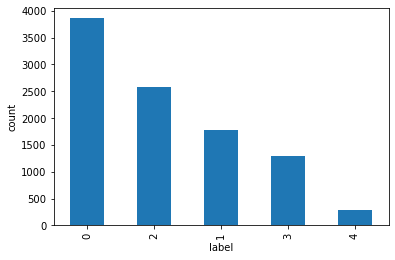

In [56]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

### 관찰
데이터 세트가 불균형적이므로 다수 클래스는 덜 가중치 부여하고 소수 클래스는 더 가중치를 부여하여 클래스 균형을 맞출 것이다.

In [57]:
# train data generator object
train_aug = ImageDataGenerator(
    rescale = 1./255
  )

# validation data generator object
valid_aug = ImageDataGenerator(
    rescale = 1./255
  )

In [58]:
# create train generator
train_generator = train_aug.flow_from_dataframe(
    dataframe = df_train_kaggle,
    directory = None,
    x_col = "filepath",
    y_col = "label",
    batch_size = batch_size,
    seed = seed,
    shuffle = True,
    class_mode = "raw",
    target_size = (image_size,image_size)
  )

Found 9786 validated image filenames.


In [59]:
# read Train.csv file which contains image names and labels and preprocess them
compi_root_path = "C:\\Users\\ngkim\\Downloads\\KneeXray\\"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"train/" + x)
df_val_compi.head()

,filename,label
0,C:\Users\ngkim\Downloads\KneeXray\train/Image_...,0
1,C:\Users\ngkim\Downloads\KneeXray\train/Image_...,1
2,C:\Users\ngkim\Downloads\KneeXray\train/Image_...,0
3,C:\Users\ngkim\Downloads\KneeXray\train/Image_...,1
4,C:\Users\ngkim\Downloads\KneeXray\train/Image_...,2


Text(0, 0.5, 'count')

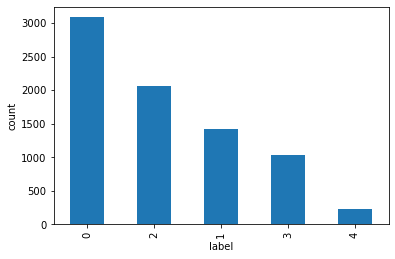

In [60]:
# class count of compitition dataset
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [61]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe( 
    dataframe = df_val_compi,
    x_col = "filename",
    y_col = "label",
    batch_size = batch_size,
    seed = seed,
    shuffle= True,
    class_mode = "raw",
    target_size = (image_size,image_size)
  )

Found 7828 validated image filenames.


### 모델
구글의 Xception을 사용

In [62]:
sel_model = model_name(weights = "imagenet",)
x =  sel_model.layers[-11].output

x = tf.keras.layers.Conv2D(filters = 1536, kernel_size = 5, padding = "same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 1024, kernel_size = 5, padding = "same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 768, kernel_size = 5, padding = "same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, padding = "same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 384, kernel_size= 3, padding = "same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = "same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = "same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 64, kernel_size= 3, padding = "same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 32, kernel_size= 3, padding = "same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 16, kernel_size= 3, padding = "same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = n_class, kernel_size = 3, padding = "same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

pic_model = Model(inputs=sel_model.input,outputs = pred)

In [63]:
pic_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [64]:
# compile
pic_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr, decay = decay),
    metrics = ["acc"],
    loss = tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_name = name+"_BS"+str(batch_size)+"_EP"+str(train_epoch)+"_IS"+str(image_size)+"_LP"+str(LP)
checkpoint_path = checkpoint_name+".ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)

my_callbacks = [
              ModelCheckpoint(
                   checkpoint_path,
                   monitor = 'val_acc',
                   verbose = 1,
                   save_weights_only = True,
                   save_best_only = True,
                   mode = "max"
                  ),
              EarlyStopping(
                   monitor = 'val_loss',
                   patience = 10,
                   verbose = 0
                  ),
              ReduceLROnPlateau(
                   monitor = 'val_loss',
                   patience = 10,
                   verbose = 1
                  )
]

### 가중치 클래스
학습 데이터 양 차이가 일정하지 않기 때문에 샘플 수에 따라 가중치 부여

In [65]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique(df_train_kaggle.label.values),
    y = df_train_kaggle.label.values
  )

class_weights = dict(enumerate(class_weights))

### Train

In [66]:
# train the model
pic_model.fit(
        train_generator,
        epochs = train_epoch,
        validation_data = valid_generator,
        callbacks = [my_callbacks],
        class_weight = class_weights
      )

# load best saved weights
pic_model.load_weights(checkpoint_path)

Epoch 1/300
1224/1224 [==============================] - 181s 146ms/step - loss: 1.4205 - acc: 0.3129 - val_loss: 1.5049 - val_acc: 0.4407

Epoch 00001: val_acc improved from -inf to 0.44073, saving model to Xception_BS8_EP300_IS224_LP11.ckpt
Epoch 2/300
1224/1224 [==============================] - 176s 144ms/step - loss: 1.2223 - acc: 0.4468 - val_loss: 1.3504 - val_acc: 0.5032

Epoch 00002: val_acc improved from 0.44073 to 0.50319, saving model to Xception_BS8_EP300_IS224_LP11.ckpt
Epoch 3/300
1224/1224 [==============================] - 176s 144ms/step - loss: 1.1015 - acc: 0.5174 - val_loss: 1.1939 - val_acc: 0.5807

Epoch 00003: val_acc improved from 0.50319 to 0.58074, saving model to Xception_BS8_EP300_IS224_LP11.ckpt
Epoch 4/300
1224/1224 [==============================] - 176s 143ms/step - loss: 1.0002 - acc: 0.5657 - val_loss: 1.0290 - val_acc: 0.6636

Epoch 00004: val_acc improved from 0.58074 to 0.66364, saving model to Xception_BS8_EP300_IS224_LP11.ckpt
Epoch 5/300
1224/12

1224/1224 [==============================] - 175s 143ms/step - loss: 0.3988 - acc: 0.9901 - val_loss: 0.4089 - val_acc: 0.9513

Epoch 00038: val_acc did not improve from 0.97509
Epoch 39/300
1224/1224 [==============================] - 174s 142ms/step - loss: 0.3878 - acc: 0.9911 - val_loss: 0.3787 - val_acc: 0.9644

Epoch 00039: val_acc did not improve from 0.97509
Epoch 40/300
1224/1224 [==============================] - 175s 143ms/step - loss: 0.3850 - acc: 0.9915 - val_loss: 0.3600 - val_acc: 0.9682

Epoch 00040: val_acc did not improve from 0.97509
Epoch 41/300
1224/1224 [==============================] - 174s 142ms/step - loss: 0.3862 - acc: 0.9929 - val_loss: 0.3473 - val_acc: 0.9747

Epoch 00041: val_acc did not improve from 0.97509
Epoch 42/300
1224/1224 [==============================] - 174s 142ms/step - loss: 0.3847 - acc: 0.9945 - val_loss: 0.3499 - val_acc: 0.9757

Epoch 00042: val_acc improved from 0.97509 to 0.97573, saving model to Xception_BS8_EP300_IS224_LP11.ckpt
Ep

### 모델 재교육

In [67]:
# train and validation split on competition data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(
    df_val_compi,
    test_size = 0.1,
    random_state = seed,
    stratify = df_val_compi.label
  )

In [68]:
train_generator = train_aug.flow_from_dataframe(
    dataframe = X_train,
    x_col = "filename",
    y_col = "label",
    batch_size = batch_size,
    seed = seed,
    shuffle = True,
    class_mode = "raw",
    target_size = (image_size,image_size)
  )

Found 7045 validated image filenames.


In [69]:
valid_generator = valid_aug.flow_from_dataframe( 
    dataframe = X_test,
    x_col = "filename",
    y_col = "label",
    batch_size = batch_size,
    seed = seed,
    shuffle = True,
    class_mode = "raw",
    target_size = (image_size,image_size)
  )

Found 783 validated image filenames.


In [70]:
# number of steps to consider 1 as  epoch
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

In [71]:
# kick off training
pic_model.fit(
        train_generator,
        steps_per_epoch = STEP_SIZE_TRAIN,
        epochs = val_epoch,
        validation_data = valid_generator,
        validation_steps = STEP_SIZE_VALID,callbacks = [my_callbacks]
      )

Epoch 1/50
880/880 [==============================] - 112s 125ms/step - loss: 0.4988 - acc: 0.9694 - val_loss: 0.2896 - val_acc: 0.9807

Epoch 00001: val_acc did not improve from 0.98199
Epoch 2/50
880/880 [==============================] - 109s 124ms/step - loss: 0.4748 - acc: 0.9800 - val_loss: 0.2868 - val_acc: 0.9832

Epoch 00002: val_acc improved from 0.98199 to 0.98325, saving model to Xception_BS8_EP300_IS224_LP11.ckpt
Epoch 3/50
880/880 [==============================] - 109s 124ms/step - loss: 0.4743 - acc: 0.9824 - val_loss: 0.2847 - val_acc: 0.9820

Epoch 00003: val_acc did not improve from 0.98325
Epoch 4/50
880/880 [==============================] - 110s 125ms/step - loss: 0.4631 - acc: 0.9848 - val_loss: 0.3048 - val_acc: 0.9742

Epoch 00004: val_acc did not improve from 0.98325
Epoch 5/50
880/880 [==============================] - 110s 125ms/step - loss: 0.4646 - acc: 0.9879 - val_loss: 0.2797 - val_acc: 0.9820

Epoch 00005: val_acc did not improve from 0.98325
Epoch 6/5

In [72]:
# load best saved weights
pic_model.load_weights(checkpoint_path)

### 혼란 매트릭스

데이터 세트가 불균형 상태이므로 모델이 어디에서 실수를 하는지 살펴보자.

In [73]:
from sklearn.metrics import precision_recall_curve
target_shape = 224
BS = 1

# test generator
compi_gen = valid_aug.flow_from_dataframe(
    dataframe = X_test,
    x_col = "filename",
    class_mode = None,
    target_size = (target_shape, target_shape),
    shuffle = False,
    batch_size = BS
  )

Found 783 validated image filenames.


In [74]:
# prediction on train data
predicition_compi = pic_model.predict(compi_gen, steps = compi_gen.n/ BS, verbose= 1)

783/783 [==============================] - 15s 18ms/step


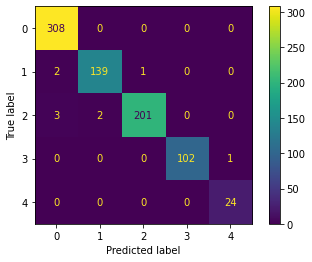

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_prediction_compi = np.argmax(predicition_compi, axis = 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels = [0, 1, 2, 3, 4])

disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = [0, 1, 2, 3, 4]
  )

disp.plot()

## test dataset 예측

In [76]:
# read the csv file
test = pd.read_csv(compi_root_path + "Test.csv")

# create test generator
test_generator = valid_aug.flow_from_dataframe(
    dataframe = test,
    directory = compi_root_path + "test",
    x_col = "filename",
    y_col = None,
    batch_size = 1,
    seed = seed,
    shuffle = False,
    class_mode = None,
    target_size = (image_size, image_size)
  )

# number of steps to consider 1 epoch
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 1958 validated image filenames.


In [77]:
# make prediction and create dataframe out of it
pred = pic_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
df_submit = pd.DataFrame({"label":np.argmax(pred, axis= 1)})
df_submit["label"].value_counts()

1958/1958 [==============================] - 36s 18ms/step


0    766
2    516
1    359
3    257
4     60
Name: label, dtype: int64

### 최적의 가중치 및 출력 예측 파일 저장

In [78]:
pic_model.save_weights(name+"_BS"+str(batch_size)+"_EP"+str(train_epoch)+"_IS"+str(image_size)+"_LP"+str(LP)+".h5")

In [79]:
cd C:\\Users\\ngkim\\Downloads\\MDL\\TermProject_중간보고\\result

C:\Users\ngkim\Downloads\MDL\TermProject_중간보고\result


In [80]:
df_submit.to_csv(name+"_BS"+str(batch_size)+"_EP"+str(train_epoch)+"_IS"+str(image_size)+"_LP"+str(LP)+".csv",index = False)

### **점수 향상을 위한 제안*
* 올바른 데이터 확대 사용
* 다른 모델 아키텍처 사용 - [CheXNet - DenseNet121 + Sigmoid](https://github.com/arnoweng/CheXNet/blob/master/model.py)
* 조립 및 쌓기
* X선 영상에 대해 사전 훈련된 모델 사용